# Setting Up Working Environment

## Sync to GitHub

In [2]:
from getpass import getpass
import os

user = getpass('github user')
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf sigmoid
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-sigmoid.git sigmoid

github user··········
github password··········
Cloning into 'sigmoid'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 176 (delta 14), reused 9 (delta 3), pack-reused 135
Receiving objects: 100% (176/176), 25.37 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (60/60), done.


## Sync to Google Drive

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Install Dependencies and CUDA

In [4]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import time
import random
import copy

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


## Import Tools to Perform Supervised Learning on KMNIST

In [0]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from sigmoid.KMNISTLearning import *

# Define Model Classes
Each model class should include a `forward` method.

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
class mLeNet5(nn.Module):
  def __init__(self):
     super(mLeNet5, self).__init__()
     self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
     self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
     self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c5 = nn.Linear(16*5*5, 1150)
     self.f6 = nn.Linear(1150, 256)
     self.output = nn.Linear(256, 10)
     self.act = nn.ReLU()
     self.dp = nn.Dropout(0.5)

  def forward(self, x):
     x = self.act(self.c1(x))
     x = self.act(self.s2(x))
     x = self.act(self.c3(x))
     x = self.act(self.s4(x))
     x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
     x = self.act(self.c5(x))
     x = self.dp(x)
     x = self.act(self.f6(x))
     x = self.dp(x)
     return self.output(x)

In [0]:
class AlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class DeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(DeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Import Data as `torch.Tensor`

In [10]:
# Import Data
path="sigmoid/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

# Size Check
print("Train Data:", X.size())
print("Test Data:", X_test.size())
print("Train Labels:", y.size())


Train Data: torch.Size([60000, 28, 28])
Test Data: torch.Size([10000, 28, 28])
Train Labels: torch.Size([60000])


# Augment Training Data

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


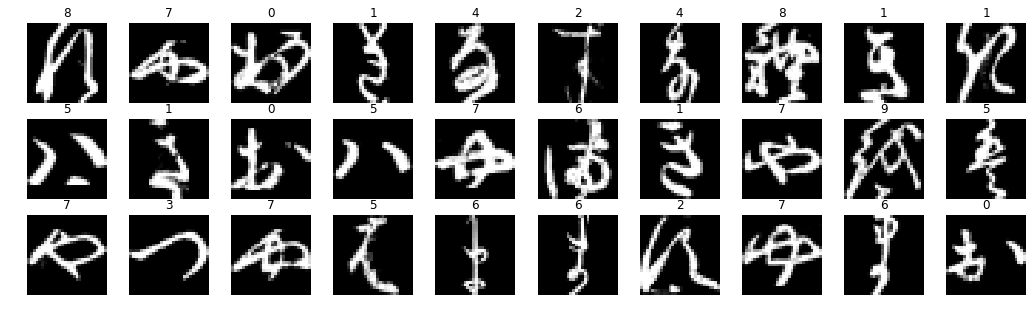

In [11]:
# Having a look at the original data
print(classmap)
r,c=3,10
fig, axs = plt.subplots(r, c, figsize=(18,5))
for img, tag, ax in zip(X[:r*c], y[:r*c], axs.flatten()):
  ax.imshow(img, cmap="gray")
  ax.set(title=tag.item())
  ax.axis("off")
plt.show()

In [12]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Cutout, 
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


def augment_data(X, y, transforms, n_add=1000):
  """ 
  Function to produce n_add augmented images from an image dataset
  Params
  -----
  X: torch.tensor of size (n_images, 28, 28) images dataset
  y: torch.tensor of size (n_images) images targets int
  transforms: albumentations.Compose object
  n_add: in number of images to add
  
  Returns
  -------
  X_aug, y_aug: np.arrays of images and targets with augmented adition
  """
  # reserve space to store augmented images
  X_aug = np.zeros((X.shape[0]+n_add, X.shape[1], X.shape[2]),dtype=uint8)
  X_aug[:X.shape[0]]=X.numpy().copy()
  
  y_aug = np.zeros(X.shape[0]+n_add)
  y_aug[:X.shape[0]] = y.numpy().copy()
  
  # keep track of how many augmented images have been added
  aug_count = 0
  
  while aug_count < n_add:
    for i in range(X.shape[0]):
      image_1c = X[i].numpy().astype(np.uint8)

      # transform to 3 channels
      image= np.zeros((28,28,3), dtype=uint8)
      image[:,:,0] = image_1c
      image[:,:,1] = image_1c
      image[:,:,2] = image_1c

      # transform and save single channel
      data = {"image": image}
      img_aug = transforms(**data)   
      img_aug = img_aug["image"][:,:,0]
      
      aug_count = aug_count + 1
      print("number of augmented images: ", aug_count)
      if aug_count >= n_add:
        break

      X_aug[X.shape[0]+aug_count] = img_aug 
      y_aug[X.shape[0]+aug_count] = int(y[i].item())
  
  return X_aug, y_aug


def strong_aug(p=0.5):
    return Compose([
        
        Cutout(num_holes=4, max_h_size=4, max_w_size=4, p=0.4),
        
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
            
        ], p=0.8),
        
        OneOf([
            MotionBlur(blur_limit=3,p=0.1),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.01),
        
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.7),
        
        OneOf([
            OpticalDistortion(p=0.1),
            GridDistortion(p=0.2),
            IAAPiecewiseAffine(p=0.2),
        ], p=0.5),
        
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            RandomBrightnessContrast(),
        ], p=0.3),
        
        HueSaturationValue(p=0.3),
    ], p=p)
  
  

number of augmented images:  1
number of augmented images:  2
number of augmented images:  3
number of augmented images:  4
number of augmented images:  5
number of augmented images:  6
number of augmented images:  7
number of augmented images:  8
number of augmented images:  9
number of augmented images:  10
number of augmented images:  11
number of augmented images:  12
number of augmented images:  13
number of augmented images:  14
number of augmented images:  15
number of augmented images:  16
number of augmented images:  17
number of augmented images:  18
number of augmented images:  19
number of augmented images:  20
number of augmented images:  21
number of augmented images:  22
number of augmented images:  23
number of augmented images:  24
number of augmented images:  25
number of augmented images:  26
number of augmented images:  27
number of augmented images:  28
number of augmented images:  29
number of augmented images:  30
number of augmented images:  31
number of augment

In [13]:
X_aug, y_aug = augment_data(X, y, strong_aug(1), n_add=20000)
X_aug, y_aug = torch.from_numpy(X_aug), torch.from_numpy(y_aug).long()

number of augmented images:  1
number of augmented images:  2
number of augmented images:  3
number of augmented images:  4
number of augmented images:  5
number of augmented images:  6
number of augmented images:  7
number of augmented images:  8
number of augmented images:  9
number of augmented images:  10
number of augmented images:  11
number of augmented images:  12
number of augmented images:  13
number of augmented images:  14
number of augmented images:  15
number of augmented images:  16
number of augmented images:  17
number of augmented images:  18
number of augmented images:  19
number of augmented images:  20
number of augmented images:  21
number of augmented images:  22
number of augmented images:  23
number of augmented images:  24
number of augmented images:  25
number of augmented images:  26
number of augmented images:  27
number of augmented images:  28
number of augmented images:  29
number of augmented images:  30
number of augmented images:  31
number of augment

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


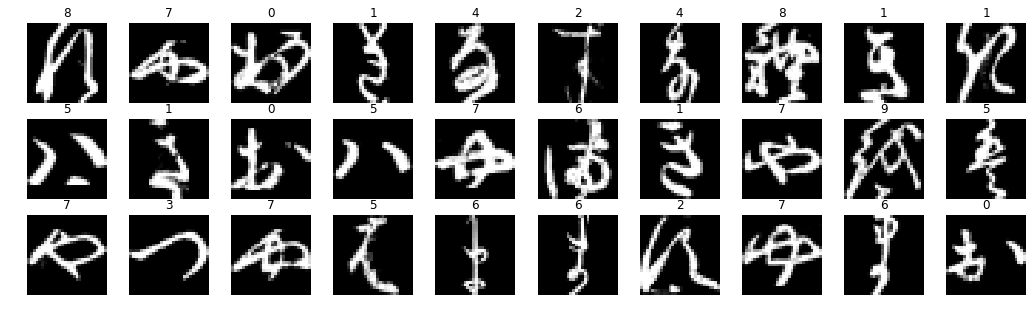

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


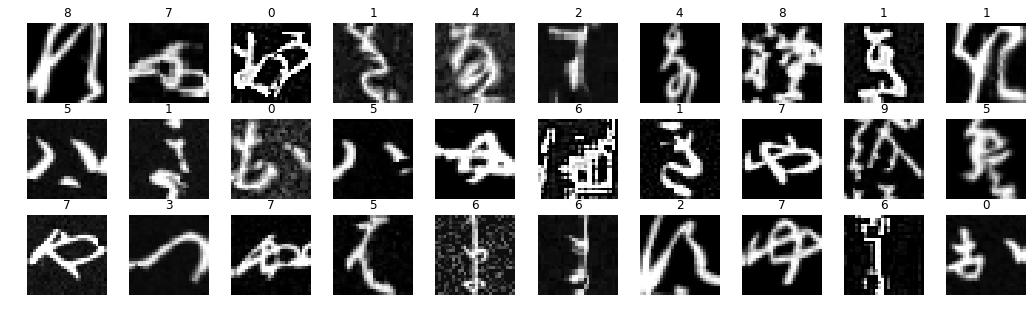

In [14]:
# Having a look at the augmented data
# Having a look at the original data
print(classmap)
r,c=3,10
fig, axs = plt.subplots(r, c, figsize=(18,5))
for img, tag, ax in zip(X[:r*c], y[:r*c], axs.flatten()):
  ax.imshow(img, cmap="gray")
  ax.set(title=tag.item())
  ax.axis("off")
plt.show()


print(classmap)
r,c=3,10
fig, axs = plt.subplots(r, c, figsize=(18,5))
for img, tag, ax in zip(X_aug[60000+1:60000+r*c+1], y_aug[60000+1:60000+r*c+1], axs.flatten()):
  ax.imshow(img, cmap="gray")
  ax.set(title=tag.item())
  ax.axis("off")
plt.show()


# Model Training, Saving and Loading

## Transfer Learning on Augmented Data

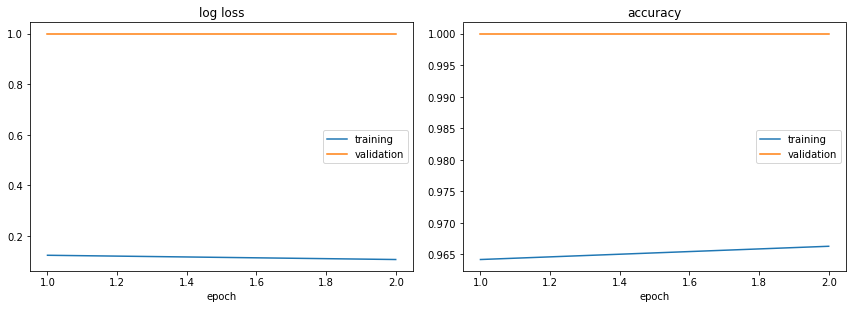

log loss:
training   (min:    0.107, max:    0.124, cur:    0.107)
validation (min:    1.000, max:    1.000, cur:    1.000)

accuracy:
training   (min:    0.964, max:    0.966, cur:    0.966)
validation (min:    1.000, max:    1.000, cur:    1.000)
Count: 0


In [0]:
# Model Loading Name
MODEL_NAME = "deepalex_old_aug_full_9806"
# Number of layers that will have non-zero learning lates
LAYERS = 2

# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 20
patience=10
early_stop_tol = 0.000
n_folds=0
weight_decay=1e-4
loss_function = nn.CrossEntropyLoss()

# Define/Load Model, Optimiser and Loss Function
alexnet = model_load("/content/gdrive/My Drive/Models/", MODEL_NAME)

# Setting the learning rate throughout the network to 0
# unless they are in the final n LAYERS
lr_dic = []
for i in range(0, len(alexnet.classifier)-LAYERS):
 lr_dic.append({'params': alexnet.classifier[i].parameters(), 'lr': 0.0})
for i in range(0, len(alexnet.features)):
 lr_dic.append({'params': alexnet.features[i].parameters(), 'lr': 0.0})

lr_dic.append({'params': alexnet.classifier[-1].parameters(), 'lr': lr})
optimiser = torch.optim.SGD(lr_dic, momentum=momentum, weight_decay=weight_decay)

# Create Supervised Learning Object
learning = SupervisedLearning(X_aug, y_aug.long(), alexnet, optimiser, loss_function, batch_size, test_batch_size,
                device=device,
                transform=False,
                seed=42, n_epochs=n_epochs,
                val_ratio=0.1, n_splits=n_folds+1,
                early_stop = True,
                patience = patience,
                tol = early_stop_tol)

learning.train_wrapper(train_full=True)

# Saving model
# Model Name
MODEL_NAME = "dAlexTransferNewAug"
path = F"/content/gdrive/My Drive/Models/"

full_save(path, MODEL_NAME, model, optimiser, loss_function, early_stop_tol, learning.logs['_i'], lr, momentum, weight_decay, n_folds, True, learning.logs['val_accuracy'], learning.logs['val_log loss'], train_time=learning.logs['time'])

# Evaluate and save test dataset prediction
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)
y_preds, sub = evaluate(X_test, model, norm_mean, norm_std,
                                      test_batch_size=test_batch_size,
                                      test_transform=None,
                                      device=device,
                                      save_to_csv=True,
                                      path=path+MODEL_NAME+'.csv')
print("\nTest Set Predictions:", y_preds)